# Task 2.4 - Concentric sampled deformation gradients

## Setup

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from keras import optimizers
from keras import losses

from src.models import CustomFFNN, InvariantsICNN
from src.data_import import load_train_test_concentric
from src.plots import plot_stress_predictions, plot_energy_prediction, plot_loss, plot_stress_currelation
from src.analytic_potential import get_C_features
from src.predict_utils import predict_multi_cases_PANN, predict_multi_cases_naive
from src.utils import get_scores

2024-12-10 13:28:12.679028: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 13:28:12.684883: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 13:28:12.697515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 13:28:12.717329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 13:28:12.724014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 13:28:12.739215: I tensorflow/core/platform/cpu_feature_gu

### Paths

In [2]:
# Calibration paths
data_dir = os.path.abspath('concentric')

In [3]:
def reached_good_prediction(labels: dict[str, np.ndarray], predictions: dict[str, np.ndarray], threshold: float = 7.0) -> bool:
    scores = get_scores(labels, predictions, 'rmse', use_total=True)
    print(f'Score: {max(list(scores.values()))}')
    return all(abs(val < threshold) for val in scores.values())

## Naive NN calibration on stress $P$

In [4]:
def train_naive_model(train_F: tf.Tensor, train_P: tf.Tensor) -> CustomFFNN:
    naive_features = get_C_features(train_F)
    naive_labels = tf.reshape(train_P, (-1, 9))

    naive_model = CustomFFNN(
        hidden_sizes=[32, 32, 32, 9],
        activations=['softplus', 'softplus', 'softplus', 'linear']
    )
    naive_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.01),
        loss=losses.MeanSquaredError()
    )
    naive_h = naive_model.fit(naive_features, naive_labels, batch_size=16, epochs=1000, verbose=0)
    naive_loss = naive_h.history['loss']
    plot_loss(naive_loss)
    return naive_model

In [5]:
def predict_and_plot_naive_model(naive_model: CustomFFNN, examples_FPW_tup: dict[str, tuple[tf.Tensor, tf.Tensor, tf.Tensor]]):
    P_naive_test_labels, P_naive_test_preds = predict_multi_cases_naive(naive_model, examples_FPW_tup)
    plot_stress_predictions(P_naive_test_labels, P_naive_test_preds)

In [6]:
def predict_and_correlate_naive_model(
        naive_model: CustomFFNN, 
        examples_FPW_tup: dict[str, tuple[tf.Tensor, tf.Tensor, tf.Tensor]]
) -> bool:
    P_naive_test_labels, P_naive_test_preds = predict_multi_cases_naive(naive_model, examples_FPW_tup)
    can_predict = reached_good_prediction(P_naive_test_labels, P_naive_test_preds, threshold=100)
    if can_predict:
        plot_stress_currelation(P_naive_test_labels, P_naive_test_preds)
    return can_predict

## PANN calibration on stress $P$ and energy $W$

In [7]:
def train_pann_model(train_F: tf.Tensor, train_P: tf.Tensor, train_W: tf.Tensor) -> InvariantsICNN:
    pann_features = train_F
    pann_labels = (train_W, train_P)

    pann_model = InvariantsICNN(
        hidden_sizes=[16, 1],
        activations=['softplus', 'linear'],
        use_output_and_derivative=True
    )
    pann_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.01),
        loss=losses.MeanSquaredError()
    )
    pann_h = pann_model.fit(pann_features, pann_labels, batch_size=32, epochs=1000, verbose=0)
    pann_loss = pann_h.history['loss']
    plot_loss(pann_loss)
    return pann_model

In [8]:
def predict_and_plot_pann_model(pann_model: InvariantsICNN, examples_FPW_tup: dict[str, tuple[tf.Tensor, tf.Tensor, tf.Tensor]]):
    (
        P_pann_test_labels, W_pann_test_labels, P_pann_test_preds, W_pann_test_preds
    ) = predict_multi_cases_PANN(pann_model, examples_FPW_tup)
    plot_stress_predictions(P_pann_test_labels, P_pann_test_preds)
    plot_energy_prediction(W_pann_test_labels, W_pann_test_preds)

In [9]:
def predict_and_correlate_pann_model(
        pann_model: InvariantsICNN, 
        examples_FPW_tup: dict[str, tuple[tf.Tensor, tf.Tensor, tf.Tensor]]
) -> bool:
    (P_pann_test_labels, _, P_pann_test_preds, _) = predict_multi_cases_PANN(pann_model, examples_FPW_tup)
    can_predict = reached_good_prediction(P_pann_test_labels, P_pann_test_preds) 
    if can_predict:
        plot_stress_currelation(P_pann_test_labels, P_pann_test_preds)
    return can_predict

## Load Datasets, calibrate and predict both models

Test size of 95.0%


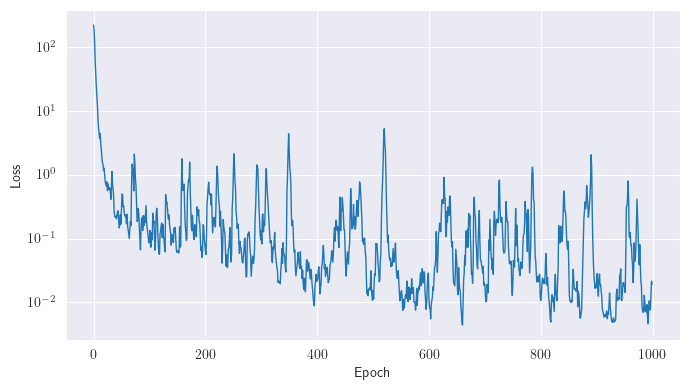

Score: 40.752132415771484


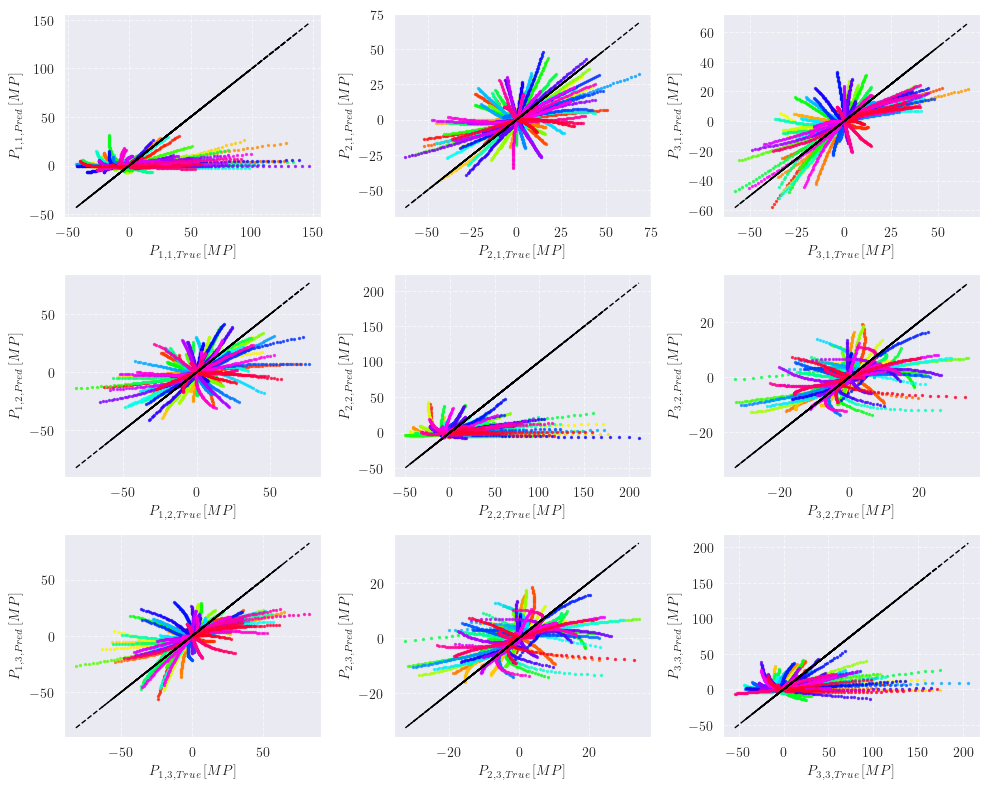

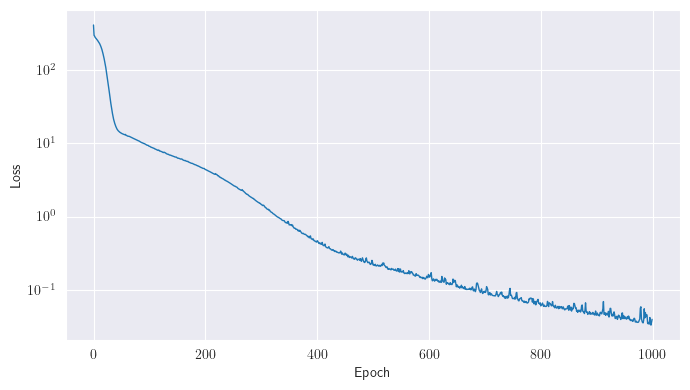

Score: 9.300055503845215


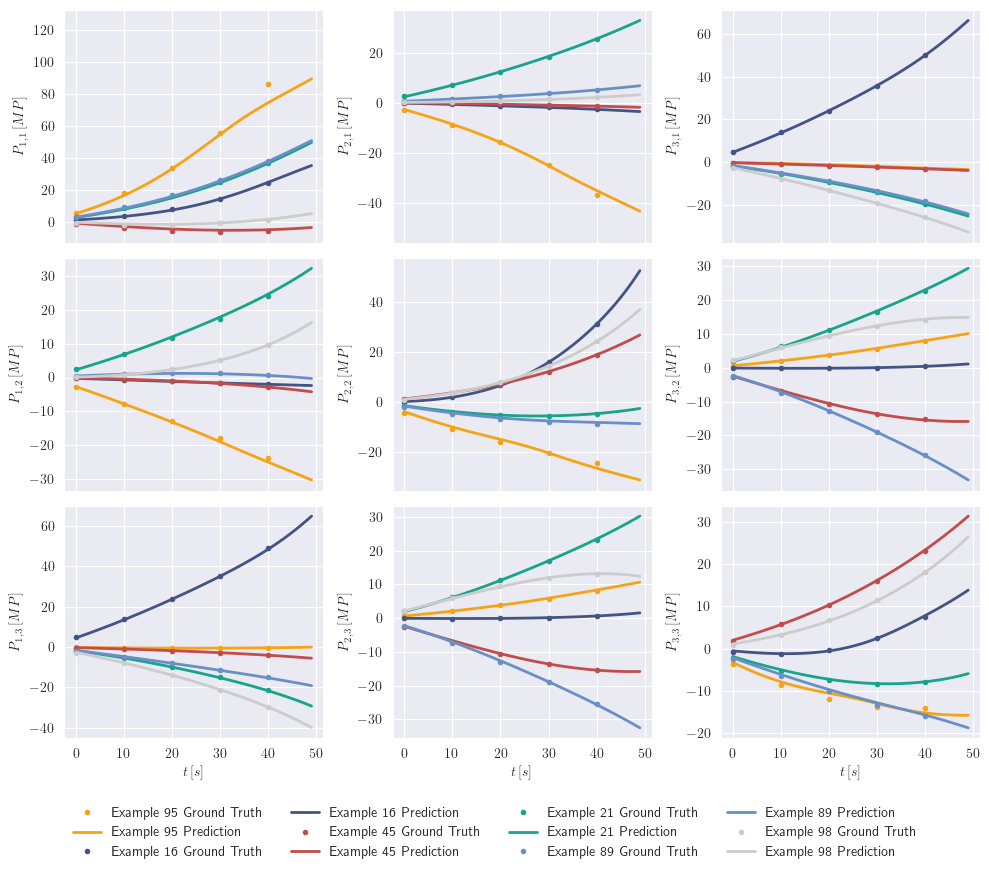

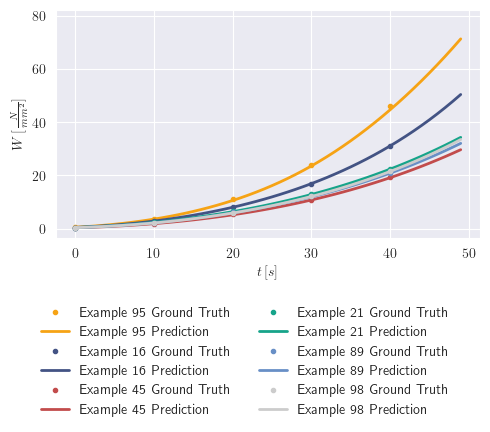

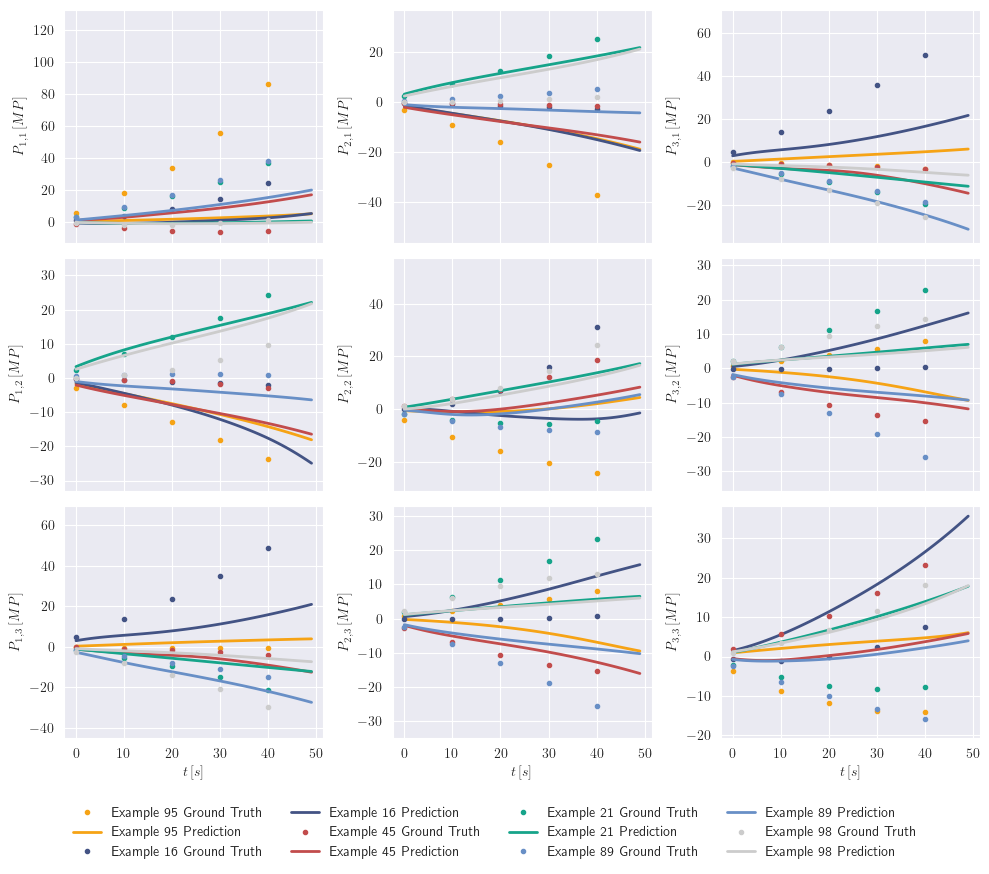

Score: 0.2543017566204071


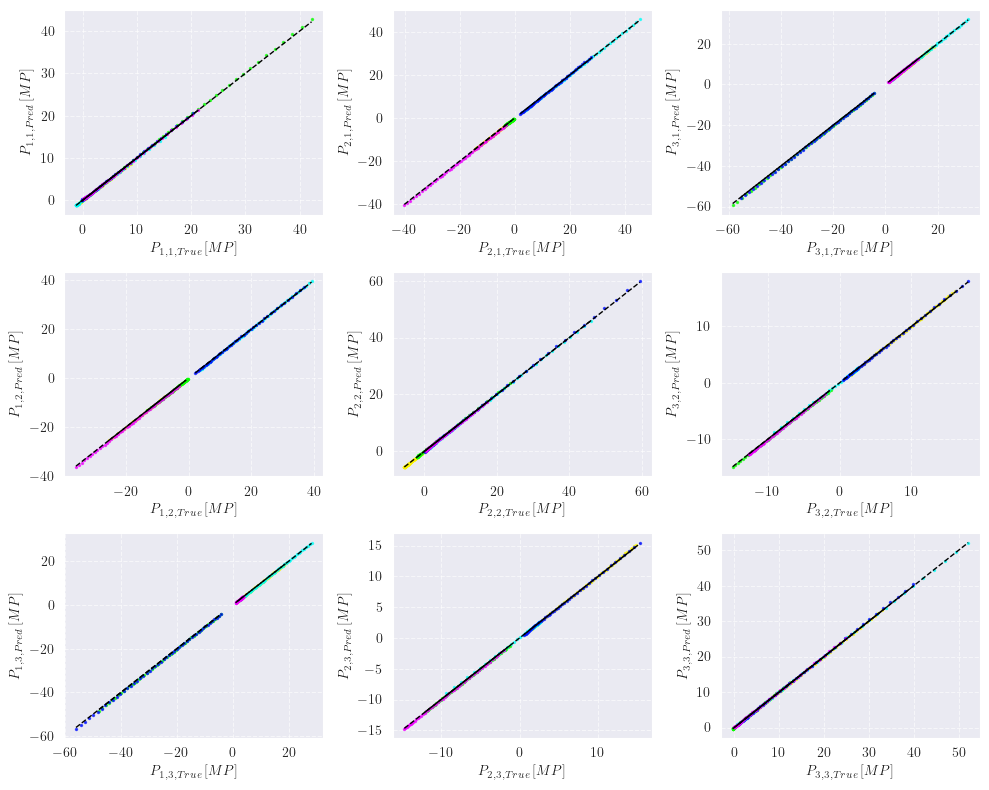

Score: 0.22698168456554413


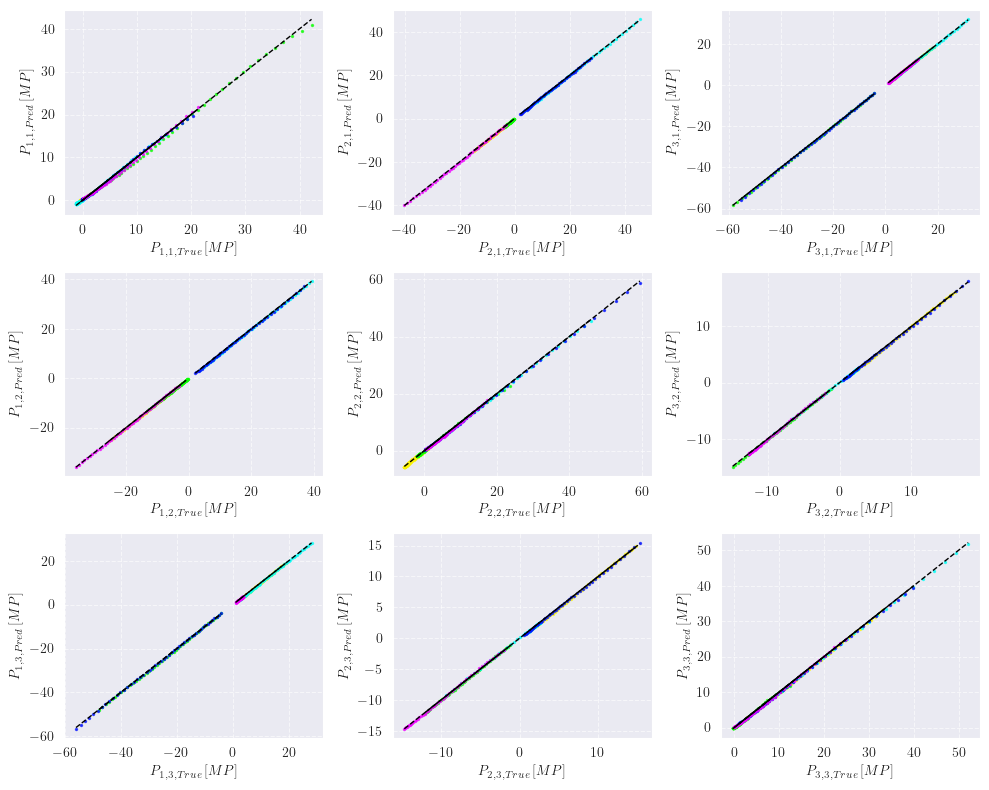

In [ ]:
for test_size in [0.95, 0.9, 0.75, 0.6, 0.5]:
    print('=' * 100)
    print(f'Test size of {test_size*100}%')
    train_data, test_data = load_train_test_concentric(data_dir, test_size=test_size)

    train_F = tf.concat([tup[0] for tup in train_data.values()], axis=0)
    train_P = tf.concat([tup[1] for tup in train_data.values()], axis=0)
    train_W = tf.concat([tup[2] for tup in train_data.values()], axis=0)

    rand_test_examples = np.random.choice(list(test_data.keys()), size=6)
    example_test_FPW_tup = {f'Example {idx}': test_data[idx] for idx in rand_test_examples}

    print('Naive Model')
    naive_model = train_naive_model(train_F, train_P)
    predict_and_correlate_naive_model(naive_model, train_data)
    can_naive_pred = predict_and_correlate_naive_model(naive_model, test_data)
    predict_and_plot_naive_model(naive_model, example_test_FPW_tup)
    

    print('PANN Model')
    pann_model = train_pann_model(train_F, train_P, train_W)
    predict_and_correlate_pann_model(pann_model, train_data)
    can_pann_pred = predict_and_correlate_pann_model(pann_model, test_data)
    predict_and_plot_pann_model(pann_model, example_test_FPW_tup)

    if can_naive_pred and can_pann_pred:
        print(f'Able to predict with a test size of {test_size}')
        break